In [ ]:
import torch
import matplotlib.pyplot as plt
import math

def closest_factors(num): 
    sq = int(math.sqrt(num)) + 1
    for i in range(sq, 1, -1): 
        if num % i == 0: 
            return i, num // i
    return 1, num

def plot_image_grid(tensor, title="Image Grid"):   
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    if tensor.ndim != 4 or tensor.shape[1] != 3:
        raise ValueError("Input tensor must have shape (N, 3, H, W) for RGB images.")

    f1, f2 = closest_factors(tensor.shape[0])

    fig, axes = plt.subplots(f1, f2, figsize=(f2 * 2, f1 * 2))
    fig.suptitle(title)

    axes = axes.flatten() if tensor.shape[0] > 1 else [axes]
    for i, ax in enumerate(axes):
        if i < tensor.shape[0]:
            img = tensor[i].detach().cpu().permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis("off")
        else:
            ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_tensor_matrix(tensor, title="Tensor Matrix", cmap="viridis"):
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    if tensor.dim() != 2:
        raise ValueError("Only 2D tensors can be plotted as matrices.")
    plt.imshow(tensor.detach().cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

def closest_factors(num): 
    sq = int(math.sqrt(num))+1
    for i in range(sq, 1, -1): 
        if(num % i == 0): 
            return i, num//i
    return 1,num

def plot_image_grid(tensor, title="Image Grid", cmap="gray"):   
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    # if tensor.shape != (16, 28, 28):
    #     raise ValueError("Input tensor must have shape (16, 28, 28).")
    f1, f2 = closest_factors(tensor.shape[0])


    fig, axes = plt.subplots(f1, f2)
    fig.suptitle(title)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(tensor[i].detach().cpu().numpy(), cmap=cmap)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # leave space for the title
    plt.show()
    
def generate_betas(beta_0, beta_T, num_steps): 
    delta = beta_T - beta_0 
    return [delta*i/(num_steps-1) + beta_0 for i in range(num_steps)] 

def generate_alpha(beta_0, beta_T, num_steps): 
    betas = generate_betas(beta_0, beta_T, num_steps)
    alphas = [1-b for b in betas]
    return alphas

def generate_alpha_bar(beta_0, beta_T, num_steps): 
    alphas = generate_alpha(beta_0, beta_T, num_steps)
    alpha_bar = [alphas[0]]
    for i in range(1, len(alphas)): alpha_bar.append(alpha_bar[i-1] * alphas[i])
    return alpha_bar

In [2]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))  
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [5]:
mnist_tensor = []
mnist_labels = []

for images, labels in train_loader:
    mnist_tensor.append(images) 
    mnist_labels.append(labels)  

for images, labels in test_loader: 
    mnist_tensor.append(images) 
    mnist_labels.append(labels)  

mnist_tensor = torch.cat(mnist_tensor, dim=0)
mnist_labels = torch.cat(mnist_labels, dim=0)

print(mnist_tensor.shape)
print(mnist_labels.shape)

torch.save(mnist_tensor, "mnist_tensor.pth")
torch.save(mnist_labels, "mnist_labels.pth")

torch.Size([70000, 1, 28, 28])
torch.Size([70000])


torch.Size([1, 28, 28])
0.001469762270504159


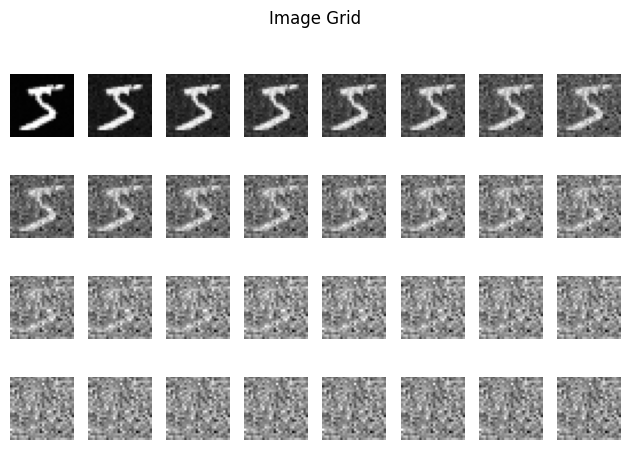

In [ ]:
mnist_tensor = torch.load("mnist_tensor.pth")
image = mnist_tensor[0]
print(image.shape)

beta_0 = 0.0001
beta_T = 0.05
num_steps = 256
a_bar = generate_alpha_bar(beta_0, beta_T, num_steps=num_steps)

demo_tensor = torch.zeros((num_steps, 1, 28, 28))
noise = torch.randn_like(image)

for i in range(num_steps): 
    x_corrupted = math.sqrt(a_bar[i]) * image + math.sqrt(1-a_bar[i]) * noise
    demo_tensor[i] = x_corrupted

print(a_bar[-1])
plot_image_grid(demo_tensor.squeeze(1)[::8])

In [12]:
from tqdm import tqdm 
import random

mnist_labels = torch.load("mnist_labels.pth")
print(mnist_labels.shape)

a = generate_alpha_bar(beta_0, beta_T, num_steps)

image_set = []
noise_set = []
time_set = []
label_set = []

num_training_cases = 999936

for i in tqdm(range(int(num_training_cases/num_steps))):
    for t in range(num_steps):
        idx = random.randint(0,mnist_tensor.shape[0]-1)

        image = mnist_tensor[idx].unsqueeze(0)
        label = mnist_labels[idx]

        noise = torch.randn_like(image)

        corrupted_image = math.sqrt(a[t]) * image + math.sqrt(1-a[t]) * noise 

        image_set.append(corrupted_image)
        noise_set.append(noise)
        time_set.append(torch.tensor([t]).unsqueeze(0))
        label_set.append(torch.tensor([label]).unsqueeze(0))

time_set = torch.concat(time_set)
noise_set = torch.concat(noise_set)
image_set = torch.concat(image_set)
label_set = torch.concat(label_set)

print(image_set.shape, time_set.shape, noise_set.shape, label_set.shape)

torch.save(image_set, "images.pth")
torch.save(time_set,  "times.pth" )
torch.save(noise_set, "noises.pth")
torch.save(label_set, "labels.pth")

torch.Size([70000])


100%|██████████| 3906/3906 [01:08<00:00, 56.76it/s]


torch.Size([999936, 1, 28, 28]) torch.Size([999936, 1]) torch.Size([999936, 1, 28, 28]) torch.Size([999936, 1])


tensor([[146,  19, 247],
        [198,  80, 180],
        [186,  35, 153]])
tensor([[9, 3, 0],
        [7, 4, 5],
        [1, 3, 7]])


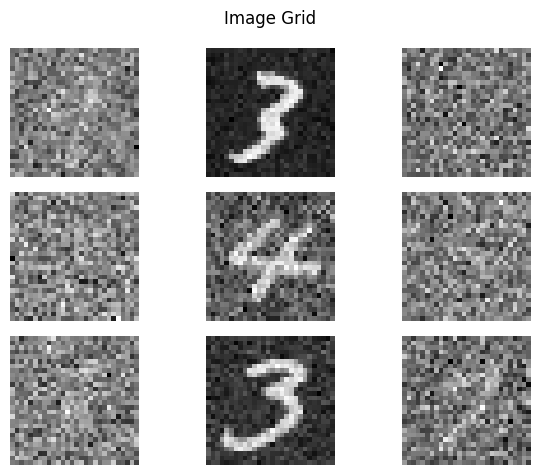

tensor(-3.7398) tensor(3.6337) tensor([146])
tensor(-1.0240) tensor(3.2387) tensor([19])
tensor(-3.0739) tensor(3.5806) tensor([247])
tensor(-3.2941) tensor(2.9553) tensor([198])
tensor(-2.1726) tensor(3.0405) tensor([80])
tensor(-3.2784) tensor(3.3182) tensor([180])
tensor(-3.4811) tensor(3.2028) tensor([186])
tensor(-1.4191) tensor(3.3507) tensor([35])
tensor(-2.9798) tensor(3.4350) tensor([153])
tensor(-3.3461) tensor(3.0598)


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

image_set = torch.load("images.pth")
noise_set = torch.load("noises.pth")
time_set = torch.load("times.pth")
label_set = torch.load("labels.pth")

dataset = TensorDataset(image_set, time_set, noise_set, label_set)
train_loader = DataLoader(dataset, batch_size=1024, shuffle=True)

for image, time, noise, label in train_loader:
    print(time[:9].view(3,3))
    print(label[:9].view(3,3))
    
    plot_image_grid(image[:9].squeeze(1))
    for i in range(9):
        print(torch.min(image[i]), torch.max(image[i]), time[i])
    break

random_noise = torch.randn((1,1,28,28))
print(torch.min(random_noise), torch.max(random_noise))